In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import re
import csv
import scipy.io

import ast
import os
import scipy.io
from sklearn.preprocessing import LabelEncoder
import time
import datetime
from datetime import datetime
import glob
from scipy.stats import zscore, norm
from neurokit2 import eda_phasic
from scipy.stats import linregress
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm


In [2]:
# this function is to convert the TimeStamp column (first column) from Unix Epoch time to standard datetime format
def TimeStamp_Conversion(ts):
  """
  we have a unix epoch time in milliseconds i.e, a string with a length of 13 charcters example:1.5789360034388428E12
  
  parameters:
  -----
  ts = Epoch timesatmp in milliseconds.

  Returns:
  -----
  Std_Unix = standard epoch timestamp in seconds.

  """

  float_Input = float(ts) # converting the string-type(1.5789360034388428E12) Unix Epoch to float-type(1578936003.4388428).

  # float input is divided by 1000 to convert the Unix epoch in milliseconds to seconds 
  Std_Unix = float_Input/1000

  datetime_Input = datetime.fromtimestamp(Std_Unix) 
  # datetime.fromtimestamp converts the unix epoch in seconds to datetime returns example:datetime.datetime(2020, 1, 13, 17, 20, 3, 438843)

  return Std_Unix

In [3]:

def column_formatting(Timestamp_DF):
  """
  Column names of Timestamp annotation excel have column index attached to column name as we only need column name we are parsing column names.

  Parameters:
  -----
  Timestamp_DF = Input the DF after reading the timestamp annotationexcel file to  get list of column names['A1- ECG baseline start','B1- ECG baseline end',.....].

  Returns:
  -----
  Parsed_ColumnNames = list of parsed column names. ['ECG baseline start','ECG baseline end',....]

  """

  Parsed_colnames = ['Subject_ID'] ## Column with Participant ID is not named, so declaring first column as Subject_ID to an empty list

  for index in range(1,len(Timestamp_DF.columns)): ## Looping through the list of timestamp annotation columns list
    column = Timestamp_DF.columns[index][4:].lstrip() ## Drop first 3 indices of each column and strip space(" ") if present as left most
    Parsed_colnames.append(column) ## appending each column name after parsing

  return Parsed_colnames ## returns list fo parsed col names

In [4]:
def Annotation_timestamp(timestamp_path, sheet_name):
  """
  This function is to change the column names of timestamp annotations table and convert timestamps from milliseconds to standart epoch format of seconds.

  Parameters:
  -----
  timestamp_path = path to the directory of file location
  sheet_name =  there are two sheets present in the file, we work on file named D.

  Results:
  -----
  VR_Timestamps_D = Clean dataframe of timestamp annotations table.

  """

  VR_TimeStamps_D = pd.read_excel(Timestamp_path, sheet_name) ## read timestamp annotation file
  Parsed_colnames = column_formatting(VR_TimeStamps_D) ## using the column_formatting function defined earlier parse columns
  VR_TimeStamps_D.columns = Parsed_colnames ## Change colnames of Dataframe using the parsed list of col names
  
  ## As timestamp is in string format and in milli seconds iterating through each column to change the timestamp to standard epoch format.
  for col in VR_TimeStamps_D.columns: 
    ## Using Timestamp_Conversion function and lambda fucntion to map the function to each row of the column.
    if col == 'Subject_ID':
      pass
    else:
      VR_TimeStamps_D[col] = VR_TimeStamps_D[col].map(lambda instance: TimeStamp_Conversion(instance)) 

  return VR_TimeStamps_D

In [5]:
def Shimmers_csv2DF(path,filename):
  """
  This function is to read Shimmer data files and create a dataframe from tidy shimmers csv tables.

  Parameters:
  -----
  path = path to directory of shimmers file folder.

  filename = name of the file to be loaded.

  Results:
  -----
  Dataframe = organized and structured Shimmers Data.

  """

  with open(path + '/' + filename, 'r',) as file: # read the file
    reader = csv.reader(file)

    lists_eachrow = []
    for row in reader:
      lists_eachrow.append(row) # append each row in reader to a list

  del lists_eachrow[0] # del first row of list as it is only about \t delimiter used

  newlists = [] 
  # loop through the list of lists and split columnar values using the delimiter 
  for list_row in lists_eachrow:
    for row in list_row:
      newlists.append(list(row.split('\t')))
  # Extract subjectID from the file name for future use
  filename_parse = filename.replace("_", " ")
  Participant_ID = ast.literal_eval(re.findall(r'\b\d+\b', filename_parse)[0])
  
  # create dataframe from the list of columnar values 
  Dataframe = pd.DataFrame(newlists, columns = newlists[0])
  Dataframe = Dataframe.drop([0,1]) # drop columns 1 and 2 which are column names and units as we already have column names for new dataframe.
  Dataframe.reset_index(drop=True, inplace=True) # reset index

  return Dataframe, Participant_ID 

In [6]:
from scipy.signal import find_peaks
def Rpeak_Indices(ecg_column):
  '''
  this function takes the ECG signals as input and detect peaks 

  inputs : ECG signal ['Shimmer_CB7C_ECG_IBI_LA_RA_CAL', 'Shimmer_CB7C_ECG_IBI_LL_LA_CAL', 'Shimmer_CB7C_ECG_IBI_LL_RA_CAL', 'Shimmer_CB7C_ECG_IBI_Vx_RL_CAL', 'Shimmer_CB7C_ECG_LA-RA_24BIT_CAL']

  output : Index of peaks  / location in the array where the peaks are occuring 
  '''
  Rpeak_Indices, _ = find_peaks(ecg_column, distance =300)
  return Rpeak_Indices


In [7]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
## A high pass filter allows frequencies higher than a cut-off value
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a
## A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a
def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q)
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z


fs = 128
cutoff_high = 0.5
cutoff_low = 2
powerline = 50
order = 5

In [8]:
# def ECG_features(path,Timestamp_path,sheet_name = 'D'):
#   # taking path location of Shimmer file as input and using glob function to find csv and text files in folder and appending each subject's filename to a list
#   os.chdir(path)
#   list_csv = glob.glob('*.{}'.format('txt'))
#   list_csv.extend(glob.glob('*.{}'.format('csv')))
  
#   # Creating an empty DataFrame to append all the features
#   Data = pd.DataFrame()

#   # loop to feature extraction on each subject file.
#   for index in tqdm(list_csv):
#     Dataframe, Participant_ID = Shimmers_csv2DF(path,index) # formatting csv file to create a clean DataFrame and extract Participant ID from file name using Shimmers_csv2DF function
#     print(Participant_ID)
#     # Convert the timestamp column in nanoseconds to milliseconds
#     # Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'] = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'].map(lambda instance: TimeStamp_Conversion(instance))
#     Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'], errors='coerce')
#     shimmers_datetime = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL']

#     # converting the below dataframes to numeric for processing 
#     print('converting the below dataframes to numeric for processing')
#     Dataframe['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], errors='coerce')

#     Dataframe['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'], errors='coerce')

#     Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], errors='coerce')

#     Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], errors='coerce')

#     # code to reduce the drifts in ECG
#     print('handling drifts in ECG')
#     filtered_LA_RA_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'], 128, 5)

#     filtered_LL_RA_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'], 128, 5)

#     filtered_Vx_RL_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], 128, 5)

#     filtered_LL_LA_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], 128, 5)

#     # below code is for debugging purpose. just to check if the above steps are correct 
#     # plt.figure(figsize=(20, 7))
#     # plt.plot(Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'][10000:20000])
#     # plt.show()

#     # selected_ecg_signal = [[shimmers_datetime], [filtered_Vx_RL_signal]]
#     # print(selected_ecg_signal)

    
#     location_of_R_peaks = Rpeak_Indices(filtered_LA_RA_signal)
#     # print(location_of_R_peaks, len(location_of_R_peaks), '\n')

#       # Dataframe with rows where R peaks are located
#     # Dataframe_Rpeak = filtered_LA_RA_signal[location_of_R_peaks]
#     # print(Dataframe_Rpeak, len(Dataframe_Rpeak), '\n')

#     # numpy array of timestamp column with indices where R peaks are located
#     timestamp = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'][location_of_R_peaks].values
#     # print(timestamp)


#     rr_intervals_list = (np.diff(timestamp))
    
#     rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list, low_rri=300, high_rri=2000)
    
#     interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")
    
#     nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")

# # This replace ectopic beats nan values with linear interpolation

#     interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
    
    
    
#     #the below package takes the list of intervalues rather than the location od peaks 
#     time_domain_features = get_time_domain_features(interpolated_nn_intervals)
#     # hrv_time = nk.hrv_time(nn_intervals_list, sampling_rate=128, show=False)
#     # print(time_domain_features, '\n')
    
#     # print(nn_intervals_list, '\n')

#     # print(time_domain_features, '\n')


#     start_window=0
#     overlap=30
#     window_length=60
#     end_window = window_length

#     ecg = interpolated_nn_intervals
#     data = pd.DataFrame() # empty dataframe to append HRV features for each window
#     while (start_window + overlap) <= len(ecg): # loop conditon to carry out windowing and calculate features till the end 
      
#       # creating start, mean and end timestamps helps to  make sure that each window completely falls in annotation period
#       Start_timestamp = timestamp[start_window]
#       Mean_timestamp = np.mean(timestamp[start_window:end_window])
#       try:
#         end_timestamp = timestamp[end_window]
#       except IndexError: 
#         # index of last window might exceed the last timestamp of our data, if this happens it will use last timestamp of data as end timsatmp of last window
#         end_timestamp = timestamp[-1]

#       ecg_window = ecg[start_window:end_window] # getting ecg samples for each winodw
#       # print(ecg_window, '/n')

#       # hrv = nk.hrv_time(ecg, sampling_rate=128, show=False) # This takes ecg signal input for each window and gives each feature output as data frame column  

#       hrv = get_time_domain_features(ecg_window) # This takes ecg signal input for each window and gives each feature output as data frame column  
#       hrv = pd.DataFrame([hrv])
      
#       # appending start, mean and end timestamp which helps in labelling event periods to each efature column
#       hrv['Start_timestamp'] = int(Start_timestamp) 
#       hrv['Mean_timestamp'] = int(Mean_timestamp)
#       hrv['end_timestamp'] = int(end_timestamp)
#       hrv['subject_ID'] = int(Participant_ID)
      
#   #     # append HRV features from each window to empty datafrme
#       data = data.append(hrv)

#       # increasing window length
#       start_window += overlap
#       end_window += overlap

#     data = data.dropna() # drop null values if any, as few rows consists of nulls values and infinity values while computing features
#     Data = Data.append(data)
#     print(Data)
#   return Data
    

      


In [9]:
# def ECG_features(path,Timestamp_path,sheet_name = 'D'):
#   # taking path location of Shimmer file as input and using glob function to find csv and text files in folder and appending each subject's filename to a list
#   os.chdir(path)
#   list_csv = glob.glob('*.{}'.format('txt'))
#   list_csv.extend(glob.glob('*.{}'.format('csv')))
  
#   # Creating an empty DataFrame to append all the features
#   Data = pd.DataFrame()

#   # loop to feature extraction on each subject file.
#   for index in tqdm(list_csv):
#     Dataframe, Participant_ID = Shimmers_csv2DF(path,index) # formatting csv file to create a clean DataFrame and extract Participant ID from file name using Shimmers_csv2DF function
#     print(Participant_ID, len(Dataframe))

#     start_window = 0
#     overlap = 7680 
#     window_length = 15360
#     end_window = window_length
#     data = pd.DataFrame()
  
#     while (end_window) < len(Dataframe):
      
#       try:
#         Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'], errors='coerce')
#         shimmers_datetime = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL']

#         # converting the below dataframes to numeric for processing 
#         print('converting the below dataframes to numeric for processing')
#         # Dataframe['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'], errors='coerce')

#         Dataframe['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'], errors='coerce')

#         # Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], errors='coerce')

#         # Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'] = pd.to_numeric(Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], errors='coerce')

#         # code to reduce the drifts in ECG
#         print('handling drifts in ECG')
#         # filtered_LA_RA_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_LA-RA_24BIT_CAL'], 128, 5)

#         filtered_LL_RA_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_LL-RA_24BIT_CAL'][start_window:end_window], 128, 5)

#         # filtered_Vx_RL_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_Vx-RL_24BIT_CAL'], 128, 5)

#         # filtered_LL_LA_signal = final_filter(Dataframe['Shimmer_CB7C_ECG_LL-LA_24BIT_CAL'], 128, 5)

#         location_of_R_peaks = Rpeak_Indices(filtered_LL_RA_signal)


#         peaks_timestamp = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'][location_of_R_peaks].values
#         timestamp = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL'][start_window:end_window]
#         # print('length', len(timestamp))
#         # print('starting timestmp', timestamp[start_window])
#         # print('ending_timestamp', timestamp[end_window-1])
#         # print(timestamp)

#         rr_intervals_list = (np.diff(peaks_timestamp))
        
#         rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list, low_rri=300, high_rri=2000)
        
#         interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")
        
#         nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")

#     # This replace ectopic beats nan values with linear interpolation

#         interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
#         time_domain_features = get_time_domain_features(interpolated_nn_intervals)


#         Start_timestamp = timestamp[start_window]
#         print(Start_timestamp)
#         Mean_timestamp = np.mean(timestamp)
#         try:
#           end_timestamp = timestamp[end_window-1]
#         except IndexError: 
#           # index of last window might exceed the last timestamp of our data, if this happens it will use last timestamp of data as end timsatmp of last window
#           end_timestamp = timestamp[-1]
        
#         ecg = interpolated_nn_intervals
#         ecg_window = ecg # getting ecg samples for each winodw

#         hrv = get_time_domain_features(ecg_window) # This takes ecg signal input for each window and gives each feature output as data frame column  
#         hrv = pd.DataFrame([hrv])
#         # appending start, mean and end timestamp which helps in labelling event periods to each efature column
#         hrv['Start_timestamp'] = int(Start_timestamp) 
#         hrv['Mean_timestamp'] = int(Mean_timestamp)
#         hrv['end_timestamp'] = int(end_timestamp)
#         hrv['subject_ID'] = int(Participant_ID)

#         end_window += overlap

#         # increasing window length
#         start_window += overlap

        
#           #     append HRV features from each window to empty datafrme
#         data = data.append(hrv)
#         data = data.dropna() # drop null values if any, as few rows consists of nulls values and infinity values while computing features
#         Data = Data.append(data)
#         print(Data)
        
#         rr_intervals_list = 0
      
#       except IndexError:
#         print("handled Index Error")
        
#   return Data
    

In [10]:

def ECG_features(path,Timestamp_path,sheet_name = 'D'):
  # taking path location of Shimmer file as input and using glob function to find csv and text files in folder and appending each subject's filename to a list
  os.chdir(path)
  list_csv = glob.glob('*.{}'.format('txt'))
  list_csv.extend(glob.glob('*.{}'.format('csv')))

  # Creating an empty DataFrame to append all the features
  data = pd.DataFrame()
  data2 = pd.DataFrame()

  # loop to feature extraction on each subject file.
  for index in tqdm(list_csv):
    Dataframe, Participant_ID = Shimmers_csv2DF(path,index)
  # formatting csv file to create a clean DataFrame and extract Participant ID from file name using Shimmers_csv2DF function
    print(Participant_ID, len(Dataframe))
    Participant_ID = pd.Series([Participant_ID]*len(Dataframe))    
    data = pd.DataFrame()
    
    timestamp = Dataframe['Shimmer_CB7C_Timestamp_Unix_CAL']
    print('considering averaged heartrates from the reference electrode')
    heart_rate = Dataframe['Shimmer_CB7C_ECGtoHR_Vx_RL_CAL']
              
    data = pd.concat([timestamp, heart_rate, Participant_ID], axis=1)
    data2 = data2.append(data)
    print(data2)
    


  return data2

In [14]:
path = 'C:/Users/govindd1/Desktop/New_Food_VR/ECG_DATA/ECG_DATA'
Timestamp_path = 'C:/Users/govindd1/Desktop/Food_VR/VR Timestamps for Phase B _ D_W_SP20.xlsx'

In [15]:
Data = ECG_features(path,Timestamp_path,sheet_name = 'D')


  0%|          | 0/10 [00:00<?, ?it/s]

1056 889607
considering averaged heartrates from the reference electrode
       Shimmer_CB7C_Timestamp_Unix_CAL Shimmer_CB7C_ECGtoHR_Vx_RL_CAL     0
0                1.5838539539093018E12                           -1.0  1056
1                1.5838539539190674E12                           -1.0  1056
2                1.5838539539210205E12                           -1.0  1056
3                1.5838539539229736E12                           -1.0  1056
4                1.5838539539249268E12                           -1.0  1056
...                                ...                            ...   ...
889602           1.5838557092003174E12              95.40372670807453  1056
889603           1.5838557092022705E12              95.40372670807453  1056
889604           1.5838557092042236E12              95.40372670807453  1056
889605           1.5838557092061768E12              95.40372670807453  1056
889606             1.58385570920813E12              95.40372670807453  1056

[889607 rows x

In [17]:
Data.to_csv('C:/Users/govindd1/Desktop/new_hrv_outputs/heartrate_avg.csv')

In [16]:
Data

,Shimmer_CB7C_Timestamp_Unix_CAL,Shimmer_CB7C_ECGtoHR_Vx_RL_CAL,0
0,1.5838539539093018E12,-1.0,1056
1,1.5838539539190674E12,-1.0,1056
2,1.5838539539210205E12,-1.0,1056
3,1.5838539539229736E12,-1.0,1056
4,1.5838539539249268E12,-1.0,1056
...,...,...,...
2313895,1.5827381903641052E12,-1.0,984
2313896,1.5827381903660583E12,-1.0,984
2313897,1.5827381903680115E12,-1.0,984
2313898,1.5827381903699646E12,-1.0,984


In [29]:
# Data = pd.read_csv('C:/Users/govindd1/Desktop/new_hrv_outputs/heartrate_avg.csv')
Data

,Unnamed: 0,Shimmer_CB7C_Timestamp_Unix_CAL,Shimmer_CB7C_ECGtoHR_Vx_RL_CAL,0
0,0,1.583854e+12,-1.0,1056
1,1,1.583854e+12,-1.0,1056
2,2,1.583854e+12,-1.0,1056
3,3,1.583854e+12,-1.0,1056
4,4,1.583854e+12,-1.0,1056
...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984
11249310,2313896,1.582738e+12,-1.0,984
11249311,2313897,1.582738e+12,-1.0,984
11249312,2313898,1.582738e+12,-1.0,984


In [30]:
Data.columns

Index(['Unnamed: 0', 'Shimmer_CB7C_Timestamp_Unix_CAL',
       'Shimmer_CB7C_ECGtoHR_Vx_RL_CAL', '0'],
      dtype='object')

In [34]:
Data = Data.rename(columns={"Shimmer_CB7C_Timestamp_Unix_CAL": "time", "Shimmer_CB7C_ECGtoHR_Vx_RL_CAL": "heartrate", '0': "subject_ID",})
Data

,Unnamed: 0,time,heartrate,subject_ID
0,0,1.583854e+12,-1.0,1056
1,1,1.583854e+12,-1.0,1056
2,2,1.583854e+12,-1.0,1056
3,3,1.583854e+12,-1.0,1056
4,4,1.583854e+12,-1.0,1056
...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984
11249310,2313896,1.582738e+12,-1.0,984
11249311,2313897,1.582738e+12,-1.0,984
11249312,2313898,1.582738e+12,-1.0,984


In [35]:
Data

,Unnamed: 0,time,heartrate,subject_ID
0,0,1.583854e+12,-1.0,1056
1,1,1.583854e+12,-1.0,1056
2,2,1.583854e+12,-1.0,1056
3,3,1.583854e+12,-1.0,1056
4,4,1.583854e+12,-1.0,1056
...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984
11249310,2313896,1.582738e+12,-1.0,984
11249311,2313897,1.582738e+12,-1.0,984
11249312,2313898,1.582738e+12,-1.0,984


In [36]:
import pandas as pd
Data['time'] =  pd.to_numeric(Data['time'], errors='coerce')
Data['heartrate'] = pd.to_numeric(Data['heartrate'], errors='coerce')
Data['subject_ID'] = pd.to_numeric(Data['subject_ID'], errors='coerce')

In [42]:
Data['Average_of_rolling_heart_rate'] = Data['heartrate'].rolling(window=7680).mean()

Data['Deviation_of_rolling_heart_rate']  = Data['heartrate'].rolling(window=7680).std()

Data['Max_rolling_heart_rate']  = Data['heartrate'].rolling(window=7680).max()

Data['Min_rolling_heart_rate']  = Data['heartrate'].rolling(window=7680).min()

Data['Median_rolling_heart_rate']  = Data['heartrate'].rolling(window=7680).mean()





In [43]:
Data

,Unnamed: 0,time,heartrate,subject_ID,Average_of_rolling_heart_rate,Deviation_of_rolling_heart_rate,Max_rolling_heart_rate,Min_rolling_heart_rate,Median_rolling_heart_rate
0,0,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
1,1,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
2,2,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
3,3,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
4,4,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0
11249310,2313896,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0
11249311,2313897,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0
11249312,2313898,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0


In [39]:
def moving_avarage_smoothing(X, k, description_str):
    S = np.zeros(X.shape[0])
    for t in tqdm(range(X.shape[0]), desc=description_str):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

In [41]:
# Data['heartrate']  = moving_avarage_smoothing(Data['heartrate'], 3000, 'smoothing')

In [44]:
subject_list = list(Data['subject_ID'].unique())
subject_list


[1056, 1058, 793, 942, 946, 961, 962, 963, 966, 984]

In [45]:
grouped = Data.groupby('subject_ID')

In [46]:
grp_1056 = grouped.get_group(1056)
grp_1058 = grouped.get_group(1058)
grp_937 = grouped.get_group(937)
grp_942 = grouped.get_group(942)

grp_946 = grouped.get_group(946)

grp_961 = grouped.get_group(961)

grp_962 = grouped.get_group(962)

grp_963 = grouped.get_group(963)

grp_966 = grouped.get_group(966)

grp_984 = grouped.get_group(984)




KeyError: 937

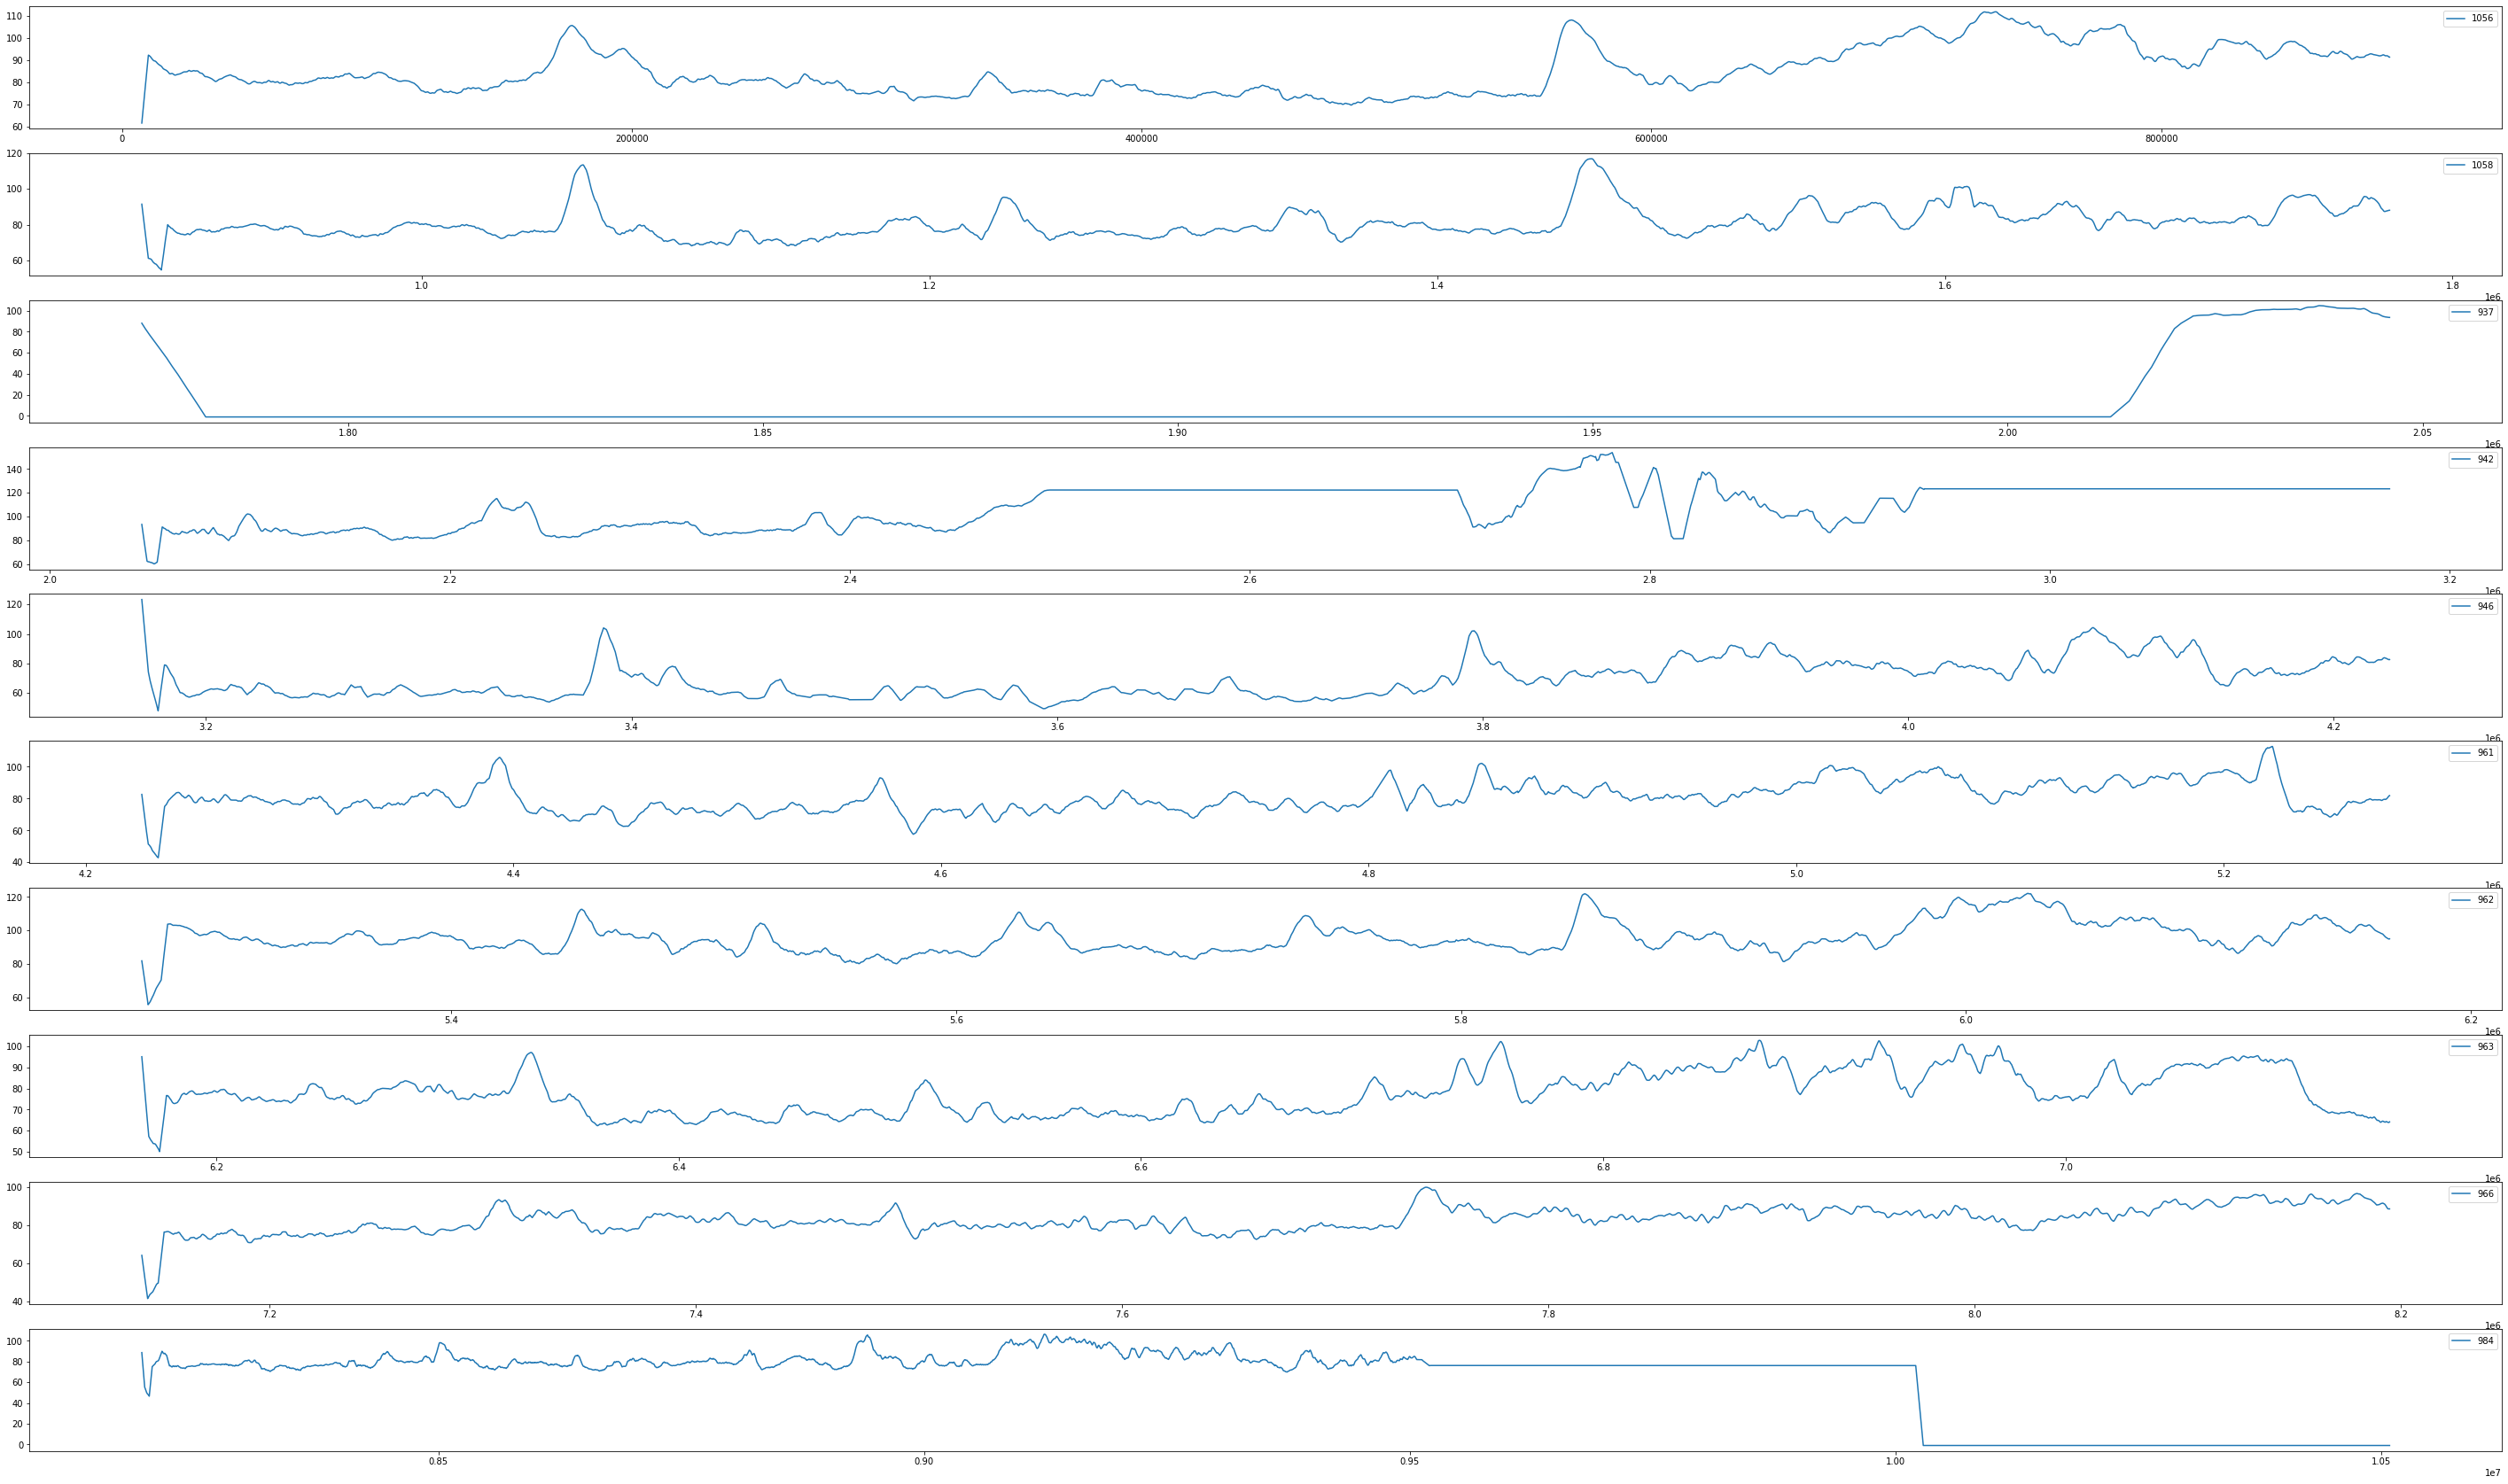

In [38]:
fig, axs = plt.subplots(10, figsize=(50,30))

# plt.figure(figsize=(30,15))

axs[0].plot(grp_1056['Averaged_heart_rate'])
axs[0].legend(['1056'], loc='best')

axs[1].plot(grp_1058['Averaged_heart_rate'])
axs[1].legend(['1058'], loc='best')


axs[2].plot(grp_937['Averaged_heart_rate'])
axs[2].legend(['937'], loc='best')


axs[3].plot(grp_942['Averaged_heart_rate'])
axs[3].legend(['942'], loc='best')


axs[4].plot(grp_946['Averaged_heart_rate'])
axs[4].legend(['946'], loc='best')


axs[5].plot(grp_961['Averaged_heart_rate'])
axs[5].legend(['961'], loc='best')


axs[6].plot(grp_962['Averaged_heart_rate'])
axs[6].legend(['962'], loc='best')


axs[7].plot(grp_963['Averaged_heart_rate'])
axs[7].legend(['963'], loc='best')


axs[8].plot(grp_966['Averaged_heart_rate'])
axs[8].legend(['966'], loc='best')


axs[9].plot(grp_984['Averaged_heart_rate'])
axs[9].legend(['984'], loc='best')











In [ ]:
# grouped

In [ ]:
# fig, ax = plt.subplots(figsize=(20,6))

# Timestamp_path = 'C:/Users/govindd1/Desktop/Food_VR_B/VR Timestamps for Phase B _ D_W_SP20.xlsx'
# VR_TimeStamps_D = pd.read_excel(Timestamp_path, sheet_name='D')
# colnames = column_formatting(VR_TimeStamps_D)
# VR_TimeStamps_D.columns = colnames
# VRBaseline_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1056,'VR baseline start']
# VRBaseline_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1056,'VR baseline end']
# Speech_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1056,'Emotion-induction speech start']
# Speech_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1056,'Emotion-induction speech end']
# Food_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1056,'Food selection start']
# Food_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1056,'food selection end']


# ax.plot(grp_1056['time'], grp_1056['heartrate'])
# ax.axvspan(int(Speech_start), int(Speech_end), color = 'red', edgecolor="black", alpha=0.4)
# ax.axvspan(int(VRBaseline_start), int(VRBaseline_end), color="blue", edgecolor="black", alpha=0.4)
# ax.axvspan(int(Food_start), int(Food_end), color="green", edgecolor="black", alpha=0.4)
# ax.legend()


In [ ]:

# fig, ax = plt.subplots(figsize=(20,6))

# Timestamp_path = 'C:/Users/govindd1/Desktop/Food_VR_B/VR Timestamps for Phase B _ D_W_SP20.xlsx'
# VR_TimeStamps_D = pd.read_excel(Timestamp_path, sheet_name='D')
# colnames = column_formatting(VR_TimeStamps_D)
# VR_TimeStamps_D.columns = colnames
# VRBaseline_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1058,'VR baseline start']
# VRBaseline_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1058,'VR baseline end']
# Speech_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1058,'Emotion-induction speech start']
# Speech_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1058,'Emotion-induction speech end']
# Food_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1058,'Food selection start']
# Food_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == 1058,'food selection end']


# ax.plot(grp_1058['time'], grp_1058['heartrate'])
# ax.axvspan(int(Speech_start), int(Speech_end), color = 'red', edgecolor="black", alpha=0.4)
# ax.axvspan(int(VRBaseline_start), int(VRBaseline_end), color="blue", edgecolor="black", alpha=0.4)
# ax.axvspan(int(Food_start), int(Food_end), color="green", edgecolor="black", alpha=0.4)
# ax.legend()


# for i in range(0, len(grp_1058['time'])):
#     if (VRBaseline_start < grp_1058['time'][i] < VRBaseline_end):
#         Data.loc[i, 'Event'] = 'Go_no_go'
#     else:
#         pass
        

In [47]:
Timestamp_path = 'C:/Users/govindd1/Desktop/Food_VR_B/VR Timestamps for Phase B _ D_W_SP20.xlsx'
VR_TimeStamps_D = pd.read_excel(Timestamp_path, sheet_name='D')
colnames = column_formatting(VR_TimeStamps_D)
VR_TimeStamps_D.columns = colnames

VR_TimeStamps_D

,Subject_ID,ECG baseline start,ECG baseline end,Go/no-go start,Go/no-go end,VR baseline start,VR baseline end,Emotion-induction preparation start,Emotion-induction preparation end,Emotion-induction speech start,Emotion-induction speech end,Food selection start,food selection end
0,4,1.576252e+12,1.576252e+12,1.576253e+12,1.576253e+12,1.576253e+12,1.576254e+12,1.576254e+12,1.576254e+12,1.576254e+12,1.576254e+12,1.576254e+12,1.576254e+12
1,877,1.579627e+12,1.579627e+12,1.579627e+12,1.579628e+12,1.579628e+12,1.579628e+12,1.579628e+12,1.579628e+12,1.579628e+12,1.579629e+12,1.579629e+12,1.579629e+12
2,820,1.578936e+12,1.578936e+12,1.578936e+12,1.578937e+12,1.578937e+12,1.578937e+12,1.578937e+12,1.578938e+12,1.578938e+12,1.578938e+12,1.578938e+12,1.578938e+12
3,937,1.581097e+12,1.581098e+12,1.581098e+12,1.581098e+12,1.581099e+12,1.581099e+12,1.581099e+12,1.581099e+12,1.581099e+12,1.581099e+12,1.581099e+12,1.581099e+12
4,942,1.582134e+12,1.582134e+12,1.582134e+12,1.582135e+12,1.582135e+12,1.582135e+12,1.582135e+12,1.582135e+12,1.582135e+12,1.582136e+12,1.582136e+12,1.582136e+12
5,793,1.582049e+12,1.582049e+12,1.582049e+12,1.582050e+12,1.582050e+12,1.582050e+12,1.582050e+12,1.582051e+12,1.582051e+12,1.582051e+12,1.582051e+12,1.582051e+12
6,961,1.582739e+12,1.582740e+12,1.582740e+12,1.582740e+12,1.582741e+12,1.582741e+12,1.582741e+12,1.582741e+12,1.582741e+12,1.582741e+12,1.582741e+12,1.582741e+12
7,963,1.582649e+12,1.582649e+12,1.582649e+12,1.582650e+12,1.582650e+12,1.582650e+12,1.582650e+12,1.582650e+12,1.582650e+12,1.582651e+12,1.582651e+12,1.582651e+12
8,984,1.582734e+12,1.582734e+12,1.582734e+12,1.582735e+12,1.582735e+12,1.582735e+12,1.582735e+12,1.582735e+12,1.582735e+12,1.582736e+12,1.582736e+12,1.582736e+12
9,962,1.583515e+12,1.583515e+12,1.583515e+12,1.583516e+12,1.583516e+12,1.583516e+12,1.583516e+12,1.583516e+12,1.583516e+12,1.583516e+12,1.583516e+12,1.583516e+12


In [48]:
Data

,Unnamed: 0,time,heartrate,subject_ID,Average_of_rolling_heart_rate,Deviation_of_rolling_heart_rate,Max_rolling_heart_rate,Min_rolling_heart_rate,Median_rolling_heart_rate
0,0,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
1,1,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
2,2,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
3,3,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
4,4,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0
11249310,2313896,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0
11249311,2313897,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0
11249312,2313898,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0


In [49]:
# This function helps to label each row of HRV feature dataframe based on start, and end timestamp assoisated with it

import numpy as np
def Label_Data(Data,VR_TimeStamps_D):
  list_subject = np.unique(Data['subject_ID']) # list out unique subjects
  
  # for each subject present in subject list we take out start and end time stamps of each event period 
  for index in list_subject:
    
    ECGBaseline_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'ECG baseline start'].iloc[0]
    ECGBaseline_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'ECG baseline end'].iloc[0]
    Go_no_go_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Go/no-go start'].iloc[0]
    Go_no_go_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Go/no-go end'].iloc[0]
    emotion_prep_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Emotion-induction preparation start'].iloc[0]
    emotion_prep_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Emotion-induction preparation end'].iloc[0]
    VRBaseline_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'VR baseline start'].iloc[0]
    VRBaseline_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'VR baseline end'].iloc[0]
    Speech_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Emotion-induction speech start'].iloc[0]
    Speech_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Emotion-induction speech end'].iloc[0]
    Food_start = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'Food selection start'].iloc[0]
    Food_end = VR_TimeStamps_D.loc[VR_TimeStamps_D['Subject_ID'] == index,'food selection end'].iloc[0]
        
    # Vectorizing pandas dataframes
    Data.loc[(ECGBaseline_start < Data['time']) & (Data['time'] < ECGBaseline_end), 'Event'] = 'ECG_Baseline'
    
    Data.loc[(Go_no_go_start < Data['time']) & (Data['time'] < Go_no_go_end), 'Event'] = 'Go_no_go'
    
    Data.loc[(emotion_prep_start < Data['time']) & (Data['time'] < emotion_prep_end), 'Event'] = 'Emotion_prep'

    Data.loc[(VRBaseline_start < Data['time']) & (Data['time'] < VRBaseline_end), 'Event'] = 'VR baseline'

    Data.loc[(Speech_start < Data['time']) & (Data['time'] < Speech_end), 'Event'] = 'Speech Emotion'

    Data.loc[(Food_start < Data['time']) & (Data['time'] < Food_end), 'Event'] = 'Food Selection'


  return Data # labelled Feature Data

In [50]:
Label_Data(Data, VR_TimeStamps_D)

,Unnamed: 0,time,heartrate,subject_ID,Average_of_rolling_heart_rate,Deviation_of_rolling_heart_rate,Max_rolling_heart_rate,Min_rolling_heart_rate,Median_rolling_heart_rate,Event
0,0,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN
11249310,2313896,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN
11249311,2313897,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN
11249312,2313898,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN


In [51]:
Data.to_csv('C:/Users/govindd1/Desktop/new_hrv_outputs/check_labels2.csv')

In [52]:
Data['Event'].value_counts()

Go_no_go          3749313
ECG_Baseline      1538809
Food Selection     674388
Speech Emotion     631740
VR baseline        626893
Emotion_prep       319784
Name: Event, dtype: int64

In [53]:
# Data = Data.drop(['event'], axis = 1)
Data

,Unnamed: 0,time,heartrate,subject_ID,Average_of_rolling_heart_rate,Deviation_of_rolling_heart_rate,Max_rolling_heart_rate,Min_rolling_heart_rate,Median_rolling_heart_rate,Event
0,0,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.583854e+12,-1.0,1056,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11249309,2313895,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN
11249310,2313896,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN
11249311,2313897,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN
11249312,2313898,1.582738e+12,-1.0,984,-1.0,0.000016,-1.0,-1.0,-1.0,NaN


In [54]:
from numpy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve,auc, roc_auc_score, make_scorer
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
from sklearn.utils import shuffle

In [67]:

rf = RandomForestClassifier(random_state = 42) # random forest classifier as rf 
logreg = LogisticRegression(solver='lbfgs',penalty='l2',max_iter=500) # Logistic Regression Classifier as logreg
knn = KNeighborsClassifier() # K-Nearest Neighbor classifier as knn

In [71]:
def Training(empty_exp_list,Data,KFold:bool):
  
  '''
  --- We are carrying out three different Binary classification experiments for each of two event periods (Baseline vs Speech, Speech vs Food Selection, Food selec vs Baseline).
      So that we will be able to discriminate the behaviour of each of the event when compared with other event.
  --- Implementing K-fold cross val and Leave One Group Out cross val using rf, knn algorithms. 
  --- This function takes HRV feature data as input along with KFold Boolean value when True computes K-fold Cross val and when False computes LOGO cross val
  --- In the LOGO Cross val we are computing the mean scores of all the subjects and also scores while subject is left out.
  --- We are getting accuracy score and area under the curve score of each experiment with above mentioned models as dictionary key value pairs.
  '''

  # split data with relevance to event periods in each experiment and convert event column to category type
  ECGBaseline_Go_no_go = Data.loc[Data['Event'].isin(['ECG_Baseline','Go_no_go'])]
  ECGBaseline_Go_no_go["Event"] = ECGBaseline_Go_no_go["Event"].astype('category').cat.codes
  ECGBaseline_Emo_prep = Data.loc[Data['Event'].isin(['ECG_Baseline','Emotion_prep'])]
  ECGBaseline_Emo_prep["Event"] = ECGBaseline_Emo_prep["Event"].astype('category').cat.codes
  ECGBaseline_VRBase = Data.loc[Data['Event'].isin(['ECG_Baseline','VR baseline'])]
  ECGBaseline_VRBase["Event"] = ECGBaseline_VRBase["Event"].astype('category').cat.codes
  ECGBaseline_speech = Data.loc[Data['Event'].isin(['ECG_Baseline','Speech Emotion'])]
  ECGBaseline_speech["Event"] = ECGBaseline_speech["Event"].astype('category').cat.codes
  ECGBaseline_Food = Data.loc[Data['Event'].isin(['ECG_Baseline','Food Selection'])]
  ECGBaseline_Food["Event"] = ECGBaseline_Food["Event"].astype('category').cat.codes
  Go_no_Go_Emo_prep = Data.loc[Data['Event'].isin(['Go_no_go','Emotion_prep'])]
  Go_no_Go_Emo_prep["Event"] = Go_no_Go_Emo_prep["Event"].astype('category').cat.codes
  Go_no_Go_VRbase = Data.loc[Data['Event'].isin(['Go_no_go','VR baseline'])]
  Go_no_Go_VRbase["Event"] = Go_no_Go_VRbase["Event"].astype('category').cat.codes
  Go_no_Go_speech = Data.loc[Data['Event'].isin(['Go_no_go','Speech Emotion'])]
  Go_no_Go_speech["Event"] = Go_no_Go_speech["Event"].astype('category').cat.codes
  Go_no_Go_Food = Data.loc[Data['Event'].isin(['Go_no_go','Food Selection'])]
  Go_no_Go_Food["Event"] = Go_no_Go_Food["Event"].astype('category').cat.codes
  Emo_prep_VRbase = Data.loc[Data['Event'].isin(['Emotion_prep','VR baseline'])]
  Emo_prep_VRbase["Event"] = Emo_prep_VRbase["Event"].astype('category').cat.codes
  Emo_prep_speech = Data.loc[Data['Event'].isin(['Emotion_prep','Speech Emotion'])]
  Emo_prep_speech["Event"] = Emo_prep_speech["Event"].astype('category').cat.codes
  Emo_prep_Food = Data.loc[Data['Event'].isin(['Emotion_prep','Food Selection'])]
  Emo_prep_Food["Event"] = Emo_prep_Food["Event"].astype('category').cat.codes
  VRBaseline_Speech = Data.loc[Data['Event'].isin(['VR baseline','Speech Emotion'])]
  VRBaseline_Speech["Event"] = VRBaseline_Speech["Event"].astype('category').cat.codes
  VRBaseline_FoodSelec = Data.loc[Data['Event'].isin(['VR baseline','Food Selection'])]
  VRBaseline_FoodSelec["Event"] = VRBaseline_FoodSelec["Event"].astype('category').cat.codes
  Speech_FoodSelec = Data.loc[Data['Event'].isin(['Food Selection','Speech Emotion'])]
  Speech_FoodSelec["Event"] = Speech_FoodSelec["Event"].astype('category').cat.codes

  # Giving keys while each experiment dataframe are values
  dict_exp = {
    'ECGBaseline vs Go_no_go':ECGBaseline_Go_no_go,
              'ECGBaseline vs Emo_prep':ECGBaseline_Emo_prep,
              'ECGBaseline vs VR baseline':ECGBaseline_VRBase,
              'ECGBaseline vs Speech':ECGBaseline_speech,
              'ECGBaseline vs FoodSelec': ECGBaseline_Food,
              'Go_no_Go vs Emo_prep': Go_no_Go_Emo_prep,
              'Go_no_Go vs VR baseline': Go_no_Go_VRbase,
              'Go_no_Go vs Speech': Go_no_Go_speech,
              'Go_no_Go vs FoodSelec': Go_no_Go_Food,
              'Emo_prep vs VR baseline':Emo_prep_VRbase,
              'Emo_prep vs Speech':Emo_prep_speech,
              'Emo_prep vs FoodSelec':Emo_prep_Food,
            'VR baseline vs Speech':VRBaseline_Speech,
            'VR baseline vs VR FoodSelec':VRBaseline_FoodSelec,
            'Speech vs VR FoodSelec':Speech_FoodSelec}


  for experiment, data in dict_exp.items():
    
    # result dictionary with experiment name as key value pair
    result_dict = {'experiment':experiment}
    
    # while KFold is True(input), we are asking this function to carry out K-fold Cross Val
    if KFold == True:

      # Drop subject_ID column as K-fold does not handle subject wise analysis
      data = data.drop(['subject_ID'], axis=1)

      feature = np.array(data.iloc[:,:-1]) # feature columns
      target = np.array(data.iloc[:,-1]) # target column

      cv = StratifiedKFold(n_splits=13) # Stratified splitting of data with 13 folds

      # empty lists for accuarcy and auc scores for each algorithm
      # accuracy_rf=[]
      accuracy_logreg=[]
      # accuracy_knn=[]
      # auc_rf=[]
      auc_logreg=[]
      # auc_knn=[]
      
      # Loop to carry out predictions on each of the 13 folds and append scores to empty lists algorithm wise and mean is computed as key value apir to result_dict
      for train, test in cv.split(feature,target):
        subject_ID = None

        # fitiing both the models
        # rf_cv=rf.fit(feature[train],target[train])
        logreg_cv=logreg.fit(feature[train],target[train])
        # knn_cv=knn.fit(feature[train],target[train])

        # # predicting and finding scores of rf algorithm
        # y_pred_rf = rf_cv.predict(feature[test])
        # fpr, tpr, threshhold = roc_curve(target[test],y_pred_rf)
        # auc_RF = auc(fpr,tpr)
        # accuracy_RF = accuracy_score(target[test],y_pred_rf)

        # accuracy_rf.append(accuracy_RF)
        # auc_rf.append(auc_RF)

        # predicting and finding scores of logreg algorithm
        y_pred_logreg = logreg_cv.predict(feature[test])
        fpr, tpr, threshhold = roc_curve(target[test],y_pred_logreg)
        auc_LR = auc(fpr,tpr)
        accuracy_LR = accuracy_score(target[test],y_pred_logreg)

        accuracy_logreg.append(accuracy_LR)
        auc_logreg.append(auc_LR)
        
        # predicting and finding scores of knn algorithm
        # y_pred_knn = knn_cv.predict(feature[test])
        # fpr, tpr, threshhold = roc_curve(target[test],y_pred_logreg)
        # auc_KNN = auc(fpr,tpr)
        # accuracy_KNN = accuracy_score(target[test],y_pred_knn)

        # accuracy_knn.append(accuracy_KNN)
        # auc_knn.append(auc_KNN)

    else: # Where KFold (input) False and the function performs LOGO cross val
      subject_id = data['subject_ID'] # taking out the subject column to pass it as list to the LOGO splits
      data = data.drop(['subject_ID'], axis=1)

      feature = np.array(data.iloc[:,:-1]) # feature columns
      target = np.array(data.iloc[:,-1]) # target column
      groups = np.array(subject_id)
    
      logo = LeaveOneGroupOut() # group wise splitting of train and test data
      logo.get_n_splits(feature, target, groups)
      logo.get_n_splits(groups=groups)

      # empty lists for accuarcy and auc scores for each algorithm
      # accuracy_rf=[]
      accuracy_logreg=[]
      # accuracy_knn=[]
      # auc_rf=[]
      auc_logreg=[]
      # auc_knn=[]

      subject_ID_avg = {}

      # Loop to carry out predictions on each of the 13 folds and append scores to empty lists algorithm wise and mean is computed as key value apir to result_dict
      # Subject wise predictions are appended to subject_ID_avg
      for train,test in logo.split(feature,target,groups):
        
        # rf_cv=rf.fit(feature[train],target[train])
        logreg_cv=logreg.fit(feature[train],target[train])
        # knn_cv=knn.fit(feature[train],target[train])

        # y_pred_rf = rf_cv.predict(feature[test])
        # fpr, tpr, threshhold = roc_curve(target[test],y_pred_rf)
        # auc_RF = auc(fpr,tpr)
        # accuracy_RF = accuracy_score(target[test],y_pred_rf)

        # accuracy_rf.append(accuracy_RF)
        # auc_rf.append(auc_RF)

        y_pred_logreg = logreg_cv.predict(feature[test])
        fpr, tpr, threshhold = roc_curve(target[test],y_pred_logreg)
        auc_LR = auc(fpr,tpr)
        accuracy_LR = accuracy_score(target[test],y_pred_logreg)

        accuracy_logreg.append(accuracy_LR)
        auc_logreg.append(auc_LR)

        # y_pred_knn = knn_cv.predict(feature[test])
        # fpr, tpr, threshhold = roc_curve(target[test],y_pred_knn)
        # auc_KNN = auc(fpr,tpr)
        # accuracy_KNN = accuracy_score(target[test],y_pred_knn)
        
        # accuracy_knn.append(accuracy_KNN)
        # auc_knn.append(auc_KNN)

        subject_ID = groups[test][0]
        subject_ID_avg[str(subject_ID)] = {
                                          # 'accuracy_rf':accuracy_RF,
                                          # 'auc_rf':auc_RF, 
                                          'accuracy_logreg':accuracy_LR,
                                          'auc_logreg':auc_LR,
                                          # 'accuracy_knn':accuracy_KNN,
                                          # 'auc_knn':auc_KNN
                                          }
    
    if KFold == True:
      pass
    else:
      result_dict['subject_ID'] = subject_ID_avg

    result_dict['accuracy_score_testing'] = {
                                              # 'rf_cv':np.mean(accuracy_rf),
                                              'logreg_cv':np.mean(accuracy_logreg),
                                              # 'knn_cv':np.mean(accuracy_knn)
                                              }

    result_dict['auc_score_testing'] = {
                                              # 'rf_cv':np.mean(auc_rf),
                                              'logreg_cv':np.mean(auc_logreg),
                                              # 'knn_cv':np.mean(auc_knn)
                                              }

    empty_exp_list.append(result_dict)

  return empty_exp_list



  # for experiment, data in tqdm(dict_exp.items()):
    
  #   # result dictionary with experiment name as key value pair
  #   result_dict = {'experiment':experiment}
    
  #   # while KFold is True(input), we are asking this function to carry out K-fold Cross Val
  #   if KFold == True:
  #     data = data.drop(['subject_ID'], axis=1) # Drop subject_ID column as K-fold does not handle subject wise analysis

  #     feature = np.array(data.iloc[:,:-1]) # feature columns
  #     target = np.array(data.iloc[:,-1]) # target column

  #     cv = StratifiedKFold(n_splits=13) # Stratified splitting of data with 13 folds
      
  #     # empty lists for accuarcy and auc scores for each algorithm
  #     accuracy_rf=[]
  #     accuracy_knn=[]
  #     auc_rf=[]
  #     auc_knn=[]
      
  #     # Loop to carry out predictions on each of the 13 folds and append scores to empty lists algorithm wise and mean is computed as key value apir to result_dict
  #     for train, test in tqdm(cv.split(feature,target)):
  #       subject_ID = None # Drop subject_ID column as K-fold does not handle subject wise analysis

  #       # fitiing both the models
  #       rf_cv=rf.fit(feature[train],target[train])
  #       knn_cv=knn.fit(feature[train],target[train])
        
  #       # predicting and finding scores of rf algorithm
  #       y_pred_rf = rf_cv.predict(feature[test])
  #       fpr, tpr, threshhold = roc_curve(target[test],y_pred_rf)
  #       auc_RF = auc(fpr,tpr)
  #       accuracy_RF = accuracy_score(target[test],y_pred_rf)

  #       # append scores to empty lists
  #       accuracy_rf.append(accuracy_RF)
  #       auc_rf.append(auc_RF)
        
  #       # predicting and finding scores of knn algorithm
  #       y_pred_knn = knn_cv.predict(feature[test])
  #       fpr, tpr, threshhold = roc_curve(target[test],y_pred_knn)
  #       auc_KNN = auc(fpr,tpr)
  #       accuracy_KNN = accuracy_score(target[test],y_pred_knn)

  #       # append scores to empty lists
  #       accuracy_knn.append(accuracy_KNN)
  #       auc_knn.append(auc_KNN)

  #   else: # Where KFold (input) False and the function performs LOGO cross val
  #     subject_id = data['subject_ID'] # taking out the subject column to pass it as list to the LOGO splits
  #     data = data.drop(['subject_ID'], axis=1) # dropping subject_ID

  #     feature = np.array(data.iloc[:,:-1]) # feature columns
  #     target = np.array(data.iloc[:,-1]) # target column
  #     groups = np.array(subject_id)
    
  #     logo = LeaveOneGroupOut() # group wise splitting of train and test data
  #     logo.get_n_splits(feature, target, groups)
  #     logo.get_n_splits(groups=groups)
      
  #     # empty lists for accuarcy and auc scores for each algorithm
  #     accuracy_rf=[]
  #     accuracy_knn=[]
  #     auc_rf=[]
  #     auc_knn=[]

  #     subject_ID_avg = {}
      
  #     # Loop to carry out predictions on each of the 13 folds and append scores to empty lists algorithm wise and mean is computed as key value apir to result_dict
  #     # Subject wise predictions are appended to subject_ID_avg
  #     for train,test in tqdm(logo.split(feature,target,groups)):
        
  #       rf_cv=rf.fit(feature[train],target[train])
  #       knn_cv=knn.fit(feature[train],target[train])

  #       y_pred_rf = rf_cv.predict(feature[test])
  #       fpr, tpr, threshhold = roc_curve(target[test],y_pred_rf)
  #       auc_RF = auc(fpr,tpr)
  #       accuracy_RF = accuracy_score(target[test],y_pred_rf)

  #       accuracy_rf.append(accuracy_RF)
  #       auc_rf.append(auc_RF)

  #       y_pred_knn = knn_cv.predict(feature[test])
  #       fpr, tpr, threshhold = roc_curve(target[test],y_pred_knn)
  #       auc_KNN = auc(fpr,tpr)
  #       accuracy_KNN = accuracy_score(target[test],y_pred_knn)
        
  #       accuracy_knn.append(accuracy_KNN)
  #       auc_knn.append(auc_KNN)

  #       subject_ID = groups[test][0]
  #       subject_ID_avg[str(subject_ID)] = {'accuracy_rf':accuracy_RF,
  #                                         'auc_rf':auc_RF,
  #                                         'accuracy_knn':accuracy_KNN,
  #                                         'auc_knn':auc_KNN}
    
  #   if KFold == True:
  #     pass
  #   else:
  #     result_dict['subject_ID'] = subject_ID_avg

  #   result_dict['accuracy_score_testing'] = {'rf_cv':np.mean(accuracy_rf),
  #                                             'knn_cv':np.mean(accuracy_knn)}

  #   result_dict['auc_score_testing'] = {'rf_cv':np.mean(auc_rf),
  #                                             'knn_cv':np.mean(auc_knn)}

  #   empty_exp_list.append(result_dict)

  # return empty_exp_list

In [72]:
KFoldCV_results = []
KFoldCV_results = Training(KFoldCV_results,Data, KFold = True) 

C:\Users\govindd1\AppData\Local\Temp/ipykernel_25500/2630074039.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ECGBaseline_Go_no_go["Event"] = ECGBaseline_Go_no_go["Event"].astype('category').cat.codes
C:\Users\govindd1\AppData\Local\Temp/ipykernel_25500/2630074039.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ECGBaseline_Emo_prep["Event"] = ECGBaseline_Emo_prep["Event"].astype('category').cat.codes
C:\Users\govindd1\AppData\Local\Temp/ipykernel_25500/2630074039.py:18: SettingWithCopyWarning: 


In [73]:
KFoldCV_results 


[{'experiment': 'ECGBaseline vs Go_no_go',
  'accuracy_score_testing': {'logreg_cv': 0.7090065244333075},
  'auc_score_testing': {'logreg_cv': 0.5}},
 {'experiment': 'ECGBaseline vs Emo_prep',
  'accuracy_score_testing': {'logreg_cv': 0.8279429654643026},
  'auc_score_testing': {'logreg_cv': 0.5}},
 {'experiment': 'ECGBaseline vs VR baseline',
  'accuracy_score_testing': {'logreg_cv': 0.7105358909078946},
  'auc_score_testing': {'logreg_cv': 0.5}},
 {'experiment': 'ECGBaseline vs Speech',
  'accuracy_score_testing': {'logreg_cv': 0.7089492105499187},
  'auc_score_testing': {'logreg_cv': 0.5}},
 {'experiment': 'ECGBaseline vs FoodSelec',
  'accuracy_score_testing': {'logreg_cv': 0.6952878573386589},
  'auc_score_testing': {'logreg_cv': 0.5}},
 {'experiment': 'Go_no_Go vs Emo_prep',
  'accuracy_score_testing': {'logreg_cv': 0.0785884435776261},
  'auc_score_testing': {'logreg_cv': 0.5}},
 {'experiment': 'Go_no_Go vs VR baseline',
  'accuracy_score_testing': {'logreg_cv': 0.85674965940888

In [74]:
KFoldCV = pd.DataFrame() # empty dataframe
# loop to append each of the index from Training functions to a new df and append that df to above empty dataframe
for index in KFoldCV_results: 
  df = pd.DataFrame(index)
  KFoldCV = KFoldCV.append(df)

In [75]:
KFoldCV.to_csv('C:/Users/govindd1/Desktop/new_hrv_outputs/heartrate_results_with_features/log_reg-Heart_rate_pred_allEvents_K-FoldCV.csv', index = True) # save it as csv

In [76]:
LOGO_results = []
LOGO_results = Training(LOGO_results,Data, KFold = False)

C:\Users\govindd1\AppData\Local\Temp/ipykernel_25500/2630074039.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ECGBaseline_Go_no_go["Event"] = ECGBaseline_Go_no_go["Event"].astype('category').cat.codes
C:\Users\govindd1\AppData\Local\Temp/ipykernel_25500/2630074039.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ECGBaseline_Emo_prep["Event"] = ECGBaseline_Emo_prep["Event"].astype('category').cat.codes
C:\Users\govindd1\AppData\Local\Temp/ipykernel_25500/2630074039.py:18: SettingWithCopyWarning: 


In [63]:
LOGO = pd.DataFrame()
for index in LOGO_results:
  df = pd.DataFrame(index)
  LOGO = LOGO.append(df)
  
LOGO.to_csv('C:/Users/govindd1/Desktop/new_hrv_outputs/heartrate_results_with_features/log_reg-Heart_rate_pred_allEvents_leave_one_groupout.csv', index = True) # save it as csv


In [64]:
list_index = LOGO.index
indices = []
for index in range(0,len(list_index)):
  try:
    element = ast.literal_eval(list_index[index])
  except ValueError:
    indices.append(list_index[index])
    
Mean_LOGO = pd.DataFrame(LOGO.loc[indices])
Mean_LOGO = Mean_LOGO.drop_duplicates()
Mean_LOGO = Mean_LOGO.drop(columns = ['subject_ID'])
Mean_LOGO.to_csv('C:/Users/govindd1/Desktop/new_hrv_outputs/heartrate_results_with_features/log_reg-Heart_rate_pred_allEvents_MEAN_leave_one_groupout.csv', index = True) # LOGO Mean Predictions

In [65]:
Subject_LOGO = LOGO.drop(indices).drop(columns = ['accuracy_score_testing','auc_score_testing'])

In [66]:
list_=[]
for w in range(0,len(Subject_LOGO)):
  index = Subject_LOGO.index
  list_.append(index[w])
  
dummy_df = pd.DataFrame()
for one in range(0,len(Subject_LOGO)):
  Dict = Subject_LOGO['subject_ID'][one]
  df = pd.DataFrame(Dict,index=[list_[one]])
  exp = Subject_LOGO['experiment'][one]
  df['experiment'] = exp
  dummy_df = dummy_df.append(df)
  
dummy_df.to_csv("C:/Users/govindd1/Desktop/new_hrv_outputs/heartrate_results_with_features/log_reg-Heart_rate_pred_allEvents_Subject_Wise_LOGO.csv", index = True) # LOGO subject wise predictions